# Hyperparameter optimization workflow

Author: Matthias Kullowatz, Bogdan Tsal-Tsalko
<br>
Version Date: 2023-07-12

## Overview

This notebook builds on the [hyperparameter optimizaton functionality](https://github.com/datarobot-community/ai-accelerators/blob/main/advanced-experimentation/Hyperparameter_Optimization/HyperParam_Opt_Core_Concepts.ipynb) exhibited by Bogdan Tsal-Tsalko in the first of DataRobot's parameter tuning accelerators. This AI Accelerator builds on the native DataRobot hyperparameter tuning by integrating the [hyperopt](http://hyperopt.github.io/hyperopt/) module into DataRobot workflows. The hyperopt module allows for a particular Bayesian approach to parameter tuning, though more generally this notebook should be seen as an example of how to leverage DataRobot's API to integrate with <i>any</i> parameter tuning framework.

### Hyperparameters for DataRobot modeling

In machine learning, hyperparameter tuning is the act of adjusting the "settings" (referred to as hyperparameters) in a machine learning algorithm, whether that's the learning rate for an XGBoost model or the activation function in a neural network. Many methods for doing this exist, with the simplest being a brute force search over every feasible combination. While this requires little effort, it's extremely time-consuming as each combination requires fitting the machine learning algorithm. To this end, practitioners strive to find more efficient ways to search for the best combination of hyperparameters to use in a given prediction problem. DataRobot employs a proprietary version of [pattern search](https://app.datarobot.com/docs/modeling/analyze-models/evaluate/adv-tuning.html#set-the-search-type) for optimization not only for the machine learning algorithm's specific hyperparameters, but also the *respective data pre-processing needed to fit the algorithm*, with the goal of quickly producing high-performance models tailored to your dataset.

While the approach used at DataRobot is sufficient in most cases, you may want to build upon DataRobot's Autopilot modeling process with custom tuning methods such as hyperopt's "Tree of Parzen Estimators" approach. In this AI Accelerator, you will explore using non-DataRobot-native hyperparameter optimization methods on the DataRobot model leaderboard. Note that best practices generally recommend to wait until the model is in a near-finished state before searching for the best hyperparameters to use. Specifically, the following have already been finalized:

- Training data (e.g., data sources)
- Model validation method (e.g., group cross-validation, random cross-validation, or backtesting. How the problem is framed influences all subsequent steps, as it changes error minimization.)
- Feature engineering (particularly, calculations driven by subject matter expertise)
- Preprocessing and data transformations (e.g., word or character tokenizers, PCA, embeddings, normalization, etc.)
- Algorithm type (e.g. GLM, tree-based, neural net)

These decisions typically have a larger impact on model performance compared to adjusting a machine learning algorithm's hyperparameters (especially when using DataRobot, as the hyperparameters chosen automatically are pretty competitive).  

### Problem setup

You have settled on a near-final model, and getting that last extra bit of performance matters for your use case. You want to perform a more exhaustive search, or perhaps as an advanced data scientist you have certain parameters you'd like to experiment with. 

### Advanced tuning and gridsearch approach

This notebook helps you learn how to access, understand, and tune blueprints for both preprocessing and model hyperparameters. You'll programmatically work with DataRobot [advanced tuning](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/adv-tuning.html) which you can then adapt to your other projects.

You'll learn how to:

* Identify specific blueprints and review hyperparameters
* Define a search space and optimization algorithm with hyperopt
* Tune hyperparameters with hyperopt's Tree of Parzen Estimators (Bayesian) approach
    
### Prerequsites

- A completed DataRobot project (example data can be accessed here: [API](https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.25.1/examples/lending_club/Predicting_Bad_Loans.html) and a [notebook](https://docs.datarobot.com/en/docs/api/guide/common-case/loan-default/loan-default-nb.html)).

- Review requirements.txt

## Setup

### Import libraries

In [1]:
import time

import datarobot as dr
from datarobot.errors import AsyncProcessUnsuccessfulError, JobNotFinished
from datarobot.models.job import Job
import graphviz
from helpers import *
from hyperopt import fmin, space_eval, STATUS_OK, tpe, Trials
import pandas as pd

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [2]:
dr.Client(config_path="drconfig.yaml")

### Create a project (optional)

Create a project from a URL in DataRobot and follow the cell below.

In [3]:
%%time
url = "https://s3.amazonaws.com/datarobot_public_datasets/10K_Lending_Club_Loans.csv"
project = dr.Project.create(url, project_name="Loan_default_hyperopt")
print("Project ID: {}".format(project.id))
project.analyze_and_model(
    target="is_bad",
    worker_count=-1,
    mode=dr.enums.AUTOPILOT_MODE.FULL_AUTO,
)
project.wait_for_autopilot(verbosity=dr.enums.VERBOSITY_LEVEL.SILENT)

# Alteratively, import an existing DataRobot project
# project = dr.Project.get('<project_id>')

Project ID: 64af2b88d6f032a15e39865a
CPU times: user 1 s, sys: 188 ms, total: 1.19 s
Wall time: 19min 14s


## Prepare for tuning a model

### Select a model

To start tuning, select the model you want to tune from an existing DataRobot project. Your project ID and model ID might be accessed through the API via `dr.Project.list(search_params=({'project_name':'YOUR_SEARCH_KEY'}))`, or simply from the URL of your project.  Alternatively, the helper function below returns a summary of the Leaderboard for a given project.

In [4]:
# To access an existing project set your project ID below
# project = dr.Project.get("project_id_see_example_below")

print("Project URL: " + "https://app.datarobot.com/projects/" + project.id + "/eda")
print("Project ID: " + project.id)

leaderboard_top = get_top_of_leaderboard(project, metric="LogLoss")

Project URL: https://app.datarobot.com/projects/64af2b88d6f032a15e39865a/eda
Project ID: 64af2b88d6f032a15e39865a
Unique blueprints tested: 37
Feature lists tested: 2
Models trained: 63
Blueprints in the project repository: 83
Feature engineering and preprocessing steps ran:  487


Top models in the leaderboard:


,model_id,model,pct,validation_LogLoss,cross_validation_LogLoss
0,64af2ce96737bffdab113858,Light Gradient Boosted Trees Classifier with E...,64.0,0.36734,0.357414
1,64af2cea6737bffdab11385c,eXtreme Gradient Boosted Trees Classifier with...,64.0,0.36780,0.357710
2,64af2ce96737bffdab113857,eXtreme Gradient Boosted Trees Classifier with...,64.0,0.36571,0.357786
3,64af2ce96737bffdab113859,Gradient Boosted Trees Classifier with Early S...,64.0,0.36608,0.357796
4,64af2e632bb2ec97f642888c,Light Gradient Boosted Trees Classifier with E...,64.0,0.36827,0.357800


The example cell below retrieves the XGBoost blueprint with Unsupervised Learning Features, which will be used in this notebook.

In [5]:
bp_from_search = [
    bp for bp in project.get_blueprints() if "Unsupervised Learning Features" in bp.model_type
][
    0
].id  # search the blueprint repository

model = Job.get(
    project_id=project.id,
    job_id=project.train(bp_from_search),  # train the blueprint or get the model results
).get_result_when_complete()

Alternative approach to select a model from the top models output.  

In [6]:
model = dr.Model.get(
    project=project.id,
    model_id=leaderboard_top.iloc[
        2
    ][  # Select a model from the top-performing models in the Leaderboard
        "model_id"
    ],
)
model

Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping and Unsupervised Learning Features')

### Inspect a blueprint

Before you start tuning, it is conceptually important to reiterate what is contained within a blueprint. In addition to the learning algorithm hyperparmeters, you also have the option to experiment with the hyperparameters of the tasks prior to the learner. 

For more information please visit the documentation on [blueprints](https://docs.datarobot.com/en/docs/modeling/analyze-models/describe/blueprints.html). 

You can visualize the processes for your selected model using the cell below to generate a chart.

BlueprintChart(24 nodes, 31 edges)


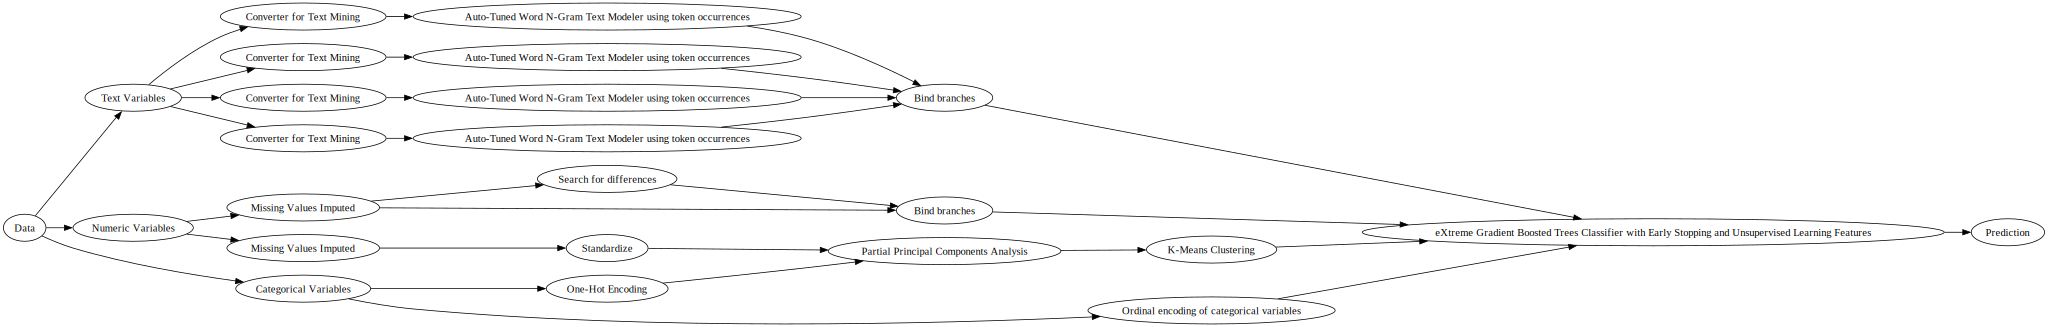

In [7]:
bpChart = model.blueprint.get_chart()
print(bpChart)
src = graphviz.Source(bpChart.to_graphviz())
src

To further understand what is happening above:

- Each of the four text variables in the feature list used by the model is being passed through an Auto-Tuned Word N-Gram Text Modeler, which fits a single-word n-gram model to each text feature in the input dataset, then uses the predictions from these models as inputs to an ElasticNet classifier. Further post-processing optimizes the weights of the text-vector via grid search.

- Numeric variables go through two paths:
    - A greedy search for differences between columns to identify new features.
    - Standardizaztion by removing the median and scaling to unit variance or mean absolute deviation. Scaled features are combined with one-hot encoded categoricals, which produces a wide matrix that is fed into PCA, then into k-means to identify clusters of latent features.
    
- Categoricals go through the above path into PCA, as well as through ordinal encoding in a separate path.

Each of these paths are fed into XGBoost. You can also access documentation around each process using the cell below.

In [8]:
bpDoc = model.blueprint.get_documents()[-1]
print("references for {}:", format(bpDoc.task))
for i, link in enumerate(bpDoc.links):
    print("{} - {}: {}".format(i, link["name"], link["url"]))

references for {}: Truncated SVD tasks
0 - sklearn TruncatedSVD: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
1 - sklearn decomposition (matrix factorization) user guide: http://scikit-learn.org/stable/modules/decomposition.html#lsa


In [9]:
print("model type: {}".format(model.model_type))
print("processes:")
for i, p in enumerate(model.blueprint.processes):
    print("{} - {}".format(i, p))

model type: eXtreme Gradient Boosted Trees Classifier with Early Stopping and Unsupervised Learning Features
processes:
0 - Ordinal encoding of categorical variables
1 - Missing Values Imputed
2 - Search for differences
3 - Converter for Text Mining
4 - Auto-Tuned Word N-Gram Text Modeler using token occurrences
5 - Standardize
6 - One-Hot Encoding
7 - Partial Principal Components Analysis
8 - K-Means Clustering
9 - eXtreme Gradient Boosted Trees Classifier with Early Stopping and Unsupervised Learning Features


### Extract tunable parameters as a dataframe. 

The function below returns all hyperparameters as a dataframe. Note- text pipelines are applied to each column of text, thus duplicate parameter names can exist.  `Keep duplicates=False` hides these parameters.

In [10]:
parameters_to_df(model.get_advanced_tuning_parameters(), keep_duplicates="first")

,task_name,parameter_name,parameter_name_type,current_value,default_value,param_type,supports_grid_search,min,max,values,parameter_id
0,Auto-Tuned Word N-Gram Text Modeler using toke...,analyzer,analyzer_select,word,word,select,NaN,NaN,NaN,"[word, char]",eyJhcmciOiJhbmFseXplciIsInZpZCI6IjEwIn0
24,Auto-Tuned Word N-Gram Text Modeler using toke...,min_df,min_df_int,2,2,int,False,0.0000,1000000000000000019884624838656,NaN,eyJhcmciOiJtaW5fZGYiLCJ2aWQiOiI2In0
51,Auto-Tuned Word N-Gram Text Modeler using toke...,use_marisa,use_marisa_select,True,True,select,NaN,NaN,NaN,"[False, True]",eyJhcmciOiJ1c2VfbWFyaXNhIiwidmlkIjoiOCJ9
27,Auto-Tuned Word N-Gram Text Modeler using toke...,min_tc,min_tc_int,0,0,int,False,0.0000,999,NaN,eyJhcmciOiJtaW5fdGMiLCJ2aWQiOiI2In0
31,Auto-Tuned Word N-Gram Text Modeler using toke...,n_features,n_features_int,262144,262144,int,False,1.0000,1048576,NaN,eyJhcmciOiJuX2ZlYXR1cmVzIiwidmlkIjoiMTIifQ
32,Auto-Tuned Word N-Gram Text Modeler using toke...,norm,norm_select,l2,l2,select,NaN,NaN,NaN,"[None, l1, l2]",eyJhcmciOiJub3JtIiwidmlkIjoiMTAifQ
38,Auto-Tuned Word N-Gram Text Modeler using toke...,segmenter,segmenter_select,None,None,select,NaN,NaN,NaN,"[None, japanese]",eyJhcmciOiJzZWdtZW50ZXIiLCJ2aWQiOiI4In0
39,Auto-Tuned Word N-Gram Text Modeler using toke...,smooth_idf,smooth_idf_select,True,True,select,NaN,NaN,NaN,"[False, True]",eyJhcmciOiJzbW9vdGhfaWRmIiwidmlkIjoiMTAifQ
41,Auto-Tuned Word N-Gram Text Modeler using toke...,stop_words,stop_words_select,0,0,select,NaN,NaN,NaN,"[False, True, english]",eyJhcmciOiJzdG9wX3dvcmRzIiwidmlkIjoiMTAifQ
42,Auto-Tuned Word N-Gram Text Modeler using toke...,sublinear_tf,sublinear_tf_select,False,False,select,NaN,NaN,NaN,"[False, True]",eyJhcmciOiJzdWJsaW5lYXJfdGYiLCJ2aWQiOiI2In0


## Use hyperopt's Bayesian tuning approach
The hyperopt package allows one to use the Tree of Parzen Estimators (Bayesian) approach to hyperparameter tuning, and you can leverage this approach with DataRobot through the API. The objective function passed into hyperopt's optimization functions is very flexible, allowing you to fit models in DataRobot and bring the automatically calculated validation, cross validation, or holdout metrics back into hyperopt for any metric available in the DataRobot project. For custom metrics not available in DataRobot, you would request the training predictions through the DataRobot API in the `objective()` function and calculate those yourself.  
<br>
### Objective function
First, define that objective function. As noted above, this hyperopt objective function gives us the flexibility to identify optimal parameter combinations for metrics not native to DataRobot, but note that the blueprint itself will not directly optimize its parameters to a custom objective function, or even a native DataRobot objective function that was not the project's default. It will use the project's default objective function (logloss in this example) in the optimization of any parameters not listed in the search space.   
<br>
Note that Python converts integers here to numpy.int64, but DataRobot won't like that. So convert back to `int` type with `.tolist()`, as seen in line 4 of the cell below.

In [11]:
def objective(search_space):
    ATS_hyperopt.set_parameter(parameter_name="subsample", value=[search_space["subsample"]])
    ATS_hyperopt.set_parameter(
        parameter_name="colsample_bytree", value=[search_space["colsample_bytree"]]
    )
    ATS_hyperopt.set_parameter(
        parameter_name="max_depth", value=[search_space["max_depth"].tolist()]
    )
    job = ATS_hyperopt.run()
    tuned_model = job.get_result_when_complete()

    loss_metric = tuned_model.metrics[model.project.metric]["crossValidation"]
    # Here you could extract the 'training predictions' from DataRobot and return your own custom metric
    return {"loss": loss_metric, "status": STATUS_OK}

### Search space

Define the search space using the random functions from the `hp` module. 

In [12]:
from hyperopt import hp

search_space = {
    "subsample": hp.uniform("subsample", 0.5, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.25, 0.75),
    "max_depth": hp.randint("max_depth", 3, 5),
}

### Optimization algorithm
Select the Tree of Parzen Estimators (tpe) tuning algorithm. 

In [13]:
algorithm = tpe.suggest

### Commence tuning
Run the models across the random search grid using the TPE approach, and record results in the `best_params` object. Print the optimized hyperparameters of the best model. 

In [14]:
%%time
ATS_hyperopt = dr.models.advanced_tuning.AdvancedTuningSession(model)
trials = Trials()
best_params = fmin(fn=objective, space=search_space, algo=algorithm, max_evals=10, trials=trials)

100%|███████████████████| 10/10 [16:11<00:00, 97.12s/trial, best loss: 0.356186]
CPU times: user 1.59 s, sys: 309 ms, total: 1.9 s
Wall time: 16min 11s


In [15]:
print(best_params)

{'colsample_bytree': 0.6216935341616984, 'max_depth': 3, 'subsample': 0.8677904050238235}


### Extract top models and evaluate

Find top model from hyperopt tuning session, by conditioning on the model type and cross validation score. Note that the hyperopt tuning was able to improve upon the orginal top model, and that it is now the best model on the Leaderboard (among those that have been cross-validated). 

In [16]:
models_with_cv = [
    m for m in project.get_models() if m.metrics["LogLoss"]["crossValidation"] is not None
]
top_hyperopt_model = [
    m
    for m in models_with_cv
    if (abs(m.metrics["LogLoss"]["crossValidation"] - np.min(trials.losses())) < 0.00001)
    & ("Unsupervised Learning Features" in m.model_type)
][0]
top_cv_model = models_with_cv[
    np.argmin([m.metrics["LogLoss"]["crossValidation"] for m in models_with_cv])
]
rec_model = dr.Model.get(project.id, project.recommended_model().parent_model_id)
pd.DataFrame(
    [
        {
            "model": "top hyperopt model",
            "cv_score": top_hyperopt_model.metrics["LogLoss"]["crossValidation"],
        },
        {
            "model": "top cross validated model",
            "cv_score": top_cv_model.metrics["LogLoss"]["crossValidation"],
        },
        {
            "model": "original recommended model",
            "cv_score": rec_model.metrics["LogLoss"]["crossValidation"],
        },
    ]
).sort_values(by=["cv_score"])

,model,cv_score
0,top hyperopt model,0.356186
1,top cross validated model,0.356186
2,original recommended model,0.357984


Now, train the top hyperopt model to 100% of the training data to prepare it for production. First you'll confirm that the holdout has been unlocked.

In [17]:
project.unlock_holdout()
top_hyperopt_model_100_job = top_hyperopt_model.train(sample_pct=100)
new_model = [j for j in project.get_model_jobs() if str(j.id) == str(top_hyperopt_model_100_job)][
    0
].get_result_when_complete()

In [18]:
print(
    "The top hyperopt model has a LogLoss of "
    + str(new_model.metrics["LogLoss"]["crossValidation"])
)
print(
    "The original recommended model has a LogLoss of "
    + str(project.recommended_model().metrics["LogLoss"]["crossValidation"])
)

The top hyperopt model has a LogLoss of 0.35519599999999996
The original recommended model has a LogLoss of 0.356794


## Conclusion
In addition to the flexible parameter tuning shown off in [the aforementioned AI Accelerator](https://github.com/datarobot-community/ai-accelerators/blob/main/advanced-experimentation/Hyperparameter_Optimization/HyperParam_Opt_Core_Concepts.ipynb), you can also leverage open source tuning modules like hyperopt with DataRobot. If you are aiming to optimize the cross-validated model scores, then even in a sequential Bayesian optimization algorithm you can still leverage DataRobot's parallelization of cross validation folds across modeling workers. 